### Métodos de Diferenças Para a Resolução da Equação do Calor: 

Este trabalho consiste em resolver um problema de contorno envolvendo a equação do calor por meio da solução exata e por aproximações utilizando os métodos FTCS, BTCS e Crank-Nicolson. O problema em questão é dado por:

\begin{equation}
    \text{E.D:}\quad \delta_{t}u = \delta^2_{x}u , \quad 0 < x < 1, \quad t > 0 \\
\end{equation}
\begin{equation}
    \text{C.F:}\quad \delta_{x}u(0,t) = 0, \quad \delta_x{u}(1,t) = 0\\
\end{equation}
\begin{equation}
    \text{C.I:}\quad u(x, 0) = 1/2 + cos(2 \pi x) - 1/2 cos(3 \pi x)
\end{equation}

### Solução exata: 
\begin{equation}
    u(x,t) = \frac{1}{2} + e^{-4\pi^2t}cos(2\pi x) - \frac{1}{2} e^{-9\pi^2t}cos(3\pi x)
\end{equation}

\begin{equation}
    \delta_{x}u(x,t) = - e^{-4\pi^2t} 2\pi sin (2\pi x) + 1/2 e^{-9\pi^2t} 3\pi sin(3 \pi x)\\
\end{equation}


In [162]:
#Numerical Differential Equations - Federal University of Minas Gerais
""" Utils """
import math, sys 
import numpy as np
import sympy as sp
from scipy import sparse
from sympy import fourier_series, pi
from scipy.fftpack import *
from scipy.sparse import diags
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

In [163]:
#Heat Diffusion in one dimensional wire within the Explicit Method
"""
λ = 2, λ = 1/2 e λ = 1/6
M = 4, M = 8, M = 10, M = 12 e M = 14
"""
#Initial Conditions
def initialConditions(x,t):
    return ((1.0/2.0)+ np.cos(2.0*pi*x) - (1.0/2.0)*np.cos(3*pi*x))

#Heat function exact solution
def Solution(x, t):
    return 1.0/2.0 + np.exp(-4*np.square(np.pi)*t)*np.cos(2*np.pi*x) - 1.0/2.0*np.exp(-9*np.square(np.pi)*t)*np.cos(3*np.pi*x)

def Nspace(M, lambd, k = 1,T = 0.5,L = 1):
    n = int(math.ceil((k*T*(M**2))/((L**2)*lambd)))
    return (n)

In [164]:
# ---- Surface plot ----
def surfaceplot(U, Uexact, tspan, xspan): 
    #meshgrid : Return coordinate matrices from coordinate vectors
    X, T = np.meshgrid(tspan, xspan)
    fig = plt.figure(figsize=plt.figaspect(0.5))
    #fig = plt.figure(figsize = (7.5,5.5))
    fig.suptitle("----- Method ----------------------- Error |(uexact - u)| -----", fontsize=12)
    
    ax1 = fig.add_subplot(1, 2, 1,projection='3d')
    surf = ax1.plot_surface(X, T, U, linewidth=0, cmap=cm.jet, antialiased=True)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Space')
    ax1.set_zlabel('U')
    
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    surf2 = ax2.plot_surface(X, T, abs(Uexact-U), linewidth=0, cmap=cm.jet, antialiased=True)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Space')
    ax2.set_zlabel('U')
    
    plt.tight_layout()
    ax1.view_init(30,230)
    ax2.view_init(30,230)
    
    fig, ax = plt.subplots()
    CS = ax.contour(X, T, abs(Uexact-U), 12)
    
    plt.draw()
    #plt.show()

In [165]:
'''
Exact Solution for 1D reaction-diffusion equation:
    u_t = k * u_xx
    
with Neumann boundary conditions 
at x=0: u_x(0,t) = 0 = sin(2*np.pi)
at x=L: u_x(L,t) = 0 = sin(2*np.pi)

with L = 1
and initial condition u(x,0) = (1.0/2.0)+ np.cos(2.0*np.pi*x) - (1.0/2.0)*np.cos(3*np.pi*x)
'''

def ExactSolution(M, T = 0.5, L = 1):
    N = (M**2) #GRID POINTS on time interval

    xspan = np.linspace(0, L, M)
    tspan = np.linspace(0, T, N)
    
    Uexact = np.zeros((M, N))
    
    for i in range(0, M):
        for j in range(0, N):
            Uexact[i][j] = Solution(xspan[i], tspan[j])
    
    return (Uexact, tspan, xspan)

def plotexact(Uexact,tspan, xspan):
    #meshgrid : Return coordinate matrices from coordinate vectors
    X, T = np.meshgrid(tspan, xspan)
    fig = plt.figure(figsize = (7.5,5.5))
    
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, T, Uexact, linewidth=0, cmap=cm.jet, antialiased=True)
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')
    ax.set_zlabel('U')
    
    plt.tight_layout()
    ax.view_init(30,230)
    
    plt.draw()

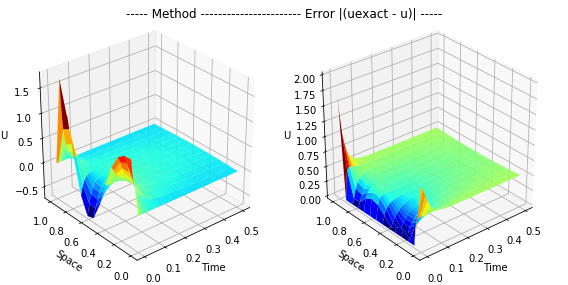

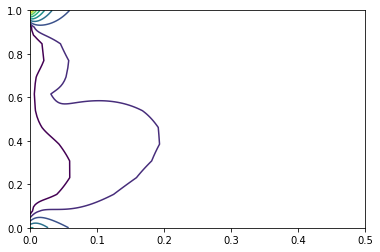

In [166]:
'''
Forward method to solve 1D reaction-diffusion equation:
    u_t = k * u_xx
    
with Neumann boundary conditions 
at x=0: u_x(0,t) = 0 = sin(2*np.pi)
at x=L: u_x(L,t) = 0 = sin(2*np.pi)

with L = 1
and initial condition u(x,0) = (1.0/2.0)+ np.cos(2.0*np.pi*x) - (1.0/2.0)*np.cos(3*np.pi*x)

u_x(x,t) = (-4.0*(np.pi**2))np.exp(-4.0*(np.pi**2)*t)*np.cos(2.0*np.pi*x) + 
            (9.0/2.0)*(np.pi**2)*np.exp(-9.0*(np.pi**2)*t)*np.cos(3*np.pi*x))
'''

def ForwardEuler(M, lambd, T = 0.5, L = 1, k = 1): 
    #Parameters needed to solve the equation within the explicit method
    # M = GRID POINTS on space interval
    N = (M**2) #GRID POINTS on time interval

    # ---- Length of the wire in x direction ---- 
    x0, xL = 0, L 

    # ----- Spatial discretization step -----
    dx = (xL - x0)/(M)

    # ---- Final time ---- 
    t0, tF = 0, T 

    # ----- Time step -----
    dt = (tF - t0)/(N)

    #lambd = dt*k/dx**2

    # ----- Creates grids -----
    xspan = np.linspace(x0, xL, M)
    tspan = np.linspace(t0, tF, N)

    # ----- Initializes matrix solution U -----
    U = np.zeros((M, N))

    # ----- Initial condition -----
    U[:,0] = (1.0/2.0)+ np.cos(2.0*np.pi*xspan) - (1.0/2.0)*np.cos(3*np.pi*xspan)

    # ----- Neumann boundary conditions -----
    U[0,:] = 0.0
    U[-1,:] = 0.0

    # -----  ftcs -----
    for k in range(0, N-1):
        for i in range(1, M-1):
            U[i, k+1] = lambd*U[i-1, k] + (1-2*lambd)*U[i,k] + lambd*U[i+1,k] 
            
    return (U, tspan, xspan)

U, tspan, xspan = ForwardEuler(M = 14, lambd = 1.0/6.0)
Uexact, x, t = ExactSolution(M = 14)
surfaceplot(U, Uexact, tspan, xspan)

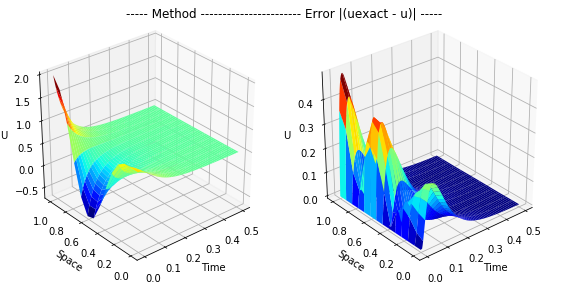

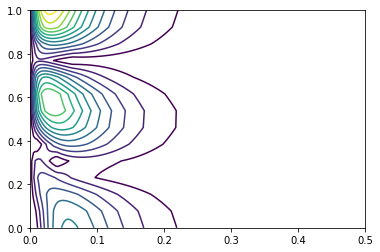

In [167]:
'''
Backward method to solve 1D reaction-diffusion equation:
    u_t = k * u_xx
    
with Neumann boundary conditions 
at x=0: u_x(0,t) = 0 = sin(2*np.pi)
at x=L: u_x(L,t) = 0 = sin(2*np.pi)

with L = 1
and initial condition u(x,0) = (1.0/2.0)+ np.cos(2.0*np.pi*x) - (1.0/2.0)*np.cos(3*np.pi*x)

u_x(x,t) = (-4.0*(np.pi**2))np.exp(-4.0*(np.pi**2)*t)*np.cos(2.0*np.pi*x) + 
            (9.0/2.0)*(np.pi**2)*np.exp(-9.0*(np.pi**2)*t)*np.cos(3*np.pi*x))
'''
def BackwardEuler(M, lambd, T = 0.5, L = 1, k = 1):
    #Parameters needed to solve the equation within the explicit method
    # M = GRID POINTS on space interval
    N = (M**2) #GRID POINTS on time interval

    # ---- Length of the wire in x direction ---- 
    x0, xL = 0, L 

    # ----- Spatial discretization step -----
    dx = (xL - x0)/(M)

    # ---- Final time ---- 
    t0, tF = 0, T 

    # ----- Time step -----
    dt = (tF - t0)/(N)

    # k = 1.0 Diffusion coefficient
    #lambd = dt*k/dx**2
    a = 1 + 2*lambd

    xspan = np.linspace(x0, xL, M)
    tspan = np.linspace(t0, tF, N)

    main_diag = (1 + 2*lambd)*np.ones((1,M))
    off_diag = -lambd*np.ones((1, M-1))

    a = main_diag.shape[1]

    diagonals = [main_diag, off_diag, off_diag]

    #Sparse Matrix diagonals
    A = sparse.diags(diagonals, [0,-1,1], shape=(a,a)).toarray()
    A[0,1] = -2*lambd
    A[M-1,M-2] = -2*lambd

    # ----- Initializes matrix U -----
    U = np.zeros((M, N))

    # ----- Initial condition -----
    U[:,0] = (1.0/2.0)+ np.cos(2.0*np.pi*xspan) - (1.0/2.0)*np.cos(3*np.pi*xspan)

    # ---- Neumann boundary conditions -----
    leftBC = np.arange(1, N+1)
    f = np.sin(2*leftBC*np.pi) #f = U[0,:] 

    rightBC = np.arange(1, N+1)
    g = np.sin(2*rightBC*np.pi) #g = U[-1,:]

    for i in range(1, N):
        c = np.zeros((M-2,1)).ravel()
        b1 = np.asarray([2*lambd*dx*f[i], 2*lambd*dx*g[i]])
        b1 = np.insert(b1, 1, c)
        b2 = np.array(U[0:M, i-1])
        b = b1 + b2  # Right hand side
        U[0:M, i] = np.linalg.solve(A,b)  # Solve x=A\b
        
    # ----- Checks if the solution is correct:
    #gc = np.allclose(np.dot(A,U[0:M,N-1]), b)
    #print(gc)
    
    return (U, tspan, xspan)

U, tspan, xspan = BackwardEuler(M = 14, lambd = 1.0/6.0)
Uexact, x, t = ExactSolution(M = 14)
surfaceplot(U, Uexact, tspan, xspan)

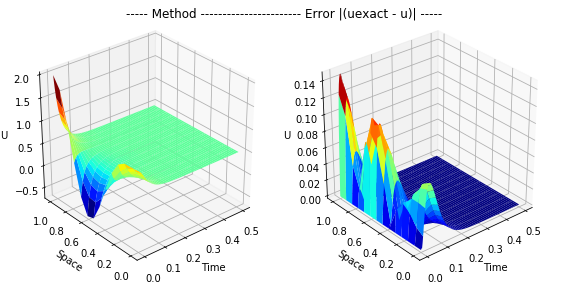

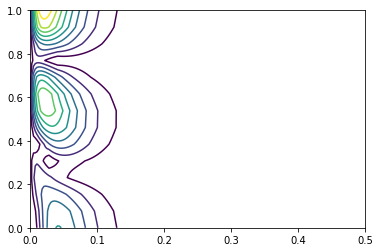

In [168]:
'''
Crank-Nicolson method to solve 1D reaction-diffusion equation:
    u_t = D * u_xx
    
with Neumann boundary conditions 
at x=0: u_x = sin(2*pi)
at x=L: u_x = sin(2*pi) 
with L=1
and initial condition u(x,0) = u(x,0) = (1.0/2.0)+ np.cos(2.0*np.pi*x) - (1.0/2.0)*np.cos(3*np.pi*x)
'''
def CrankNicolson(M, lambd, T = 0.5, L = 1, k = 1):
    #Parameters needed to solve the equation within the explicit method
    # M = GRID POINTS on space interval
    N = (M**2) #GRID POINTS on time interval

    # ---- Length of the wire in x direction ---- 
    x0, xL = 0, L

    # ----- Spatial discretization step -----
    dx = (xL - x0)/(M)

    # ---- Final time ---- 
    t0, tF = 0, T 

    # ----- Time step -----
    dt = (tF - t0)/(N)

    #lambd = dt*k/(2.0*dx**2)
    a0 = 1 + 2*lambd
    c0 = 1 - 2*lambd

    xspan = np.linspace(x0, xL, M)
    tspan = np.linspace(t0, tF, N)

    main_diag_a0 = a0*np.ones((1,M))
    off_diag_a0 = -lambd*np.ones((1, M-1))

    main_diag_c0 = c0*np.ones((1,M))
    off_diag_c0 = lambd*np.ones((1, M-1))

    # Left-hand side tri-diagonal matrix
    a = main_diag_a0.shape[1]
    diagonalsA = [main_diag_a0, off_diag_a0, off_diag_a0]
    A = sparse.diags(diagonalsA, [0,-1,1], shape=(a,a)).toarray()
    A[0,1] = -2*lambd
    A[M-1,M-2] = -2*lambd

    # Right-hand side tri-diagonal matrix
    c = main_diag_c0.shape[1]
    diagonalsC = [main_diag_c0, off_diag_c0, off_diag_c0]
    A_rhs = sparse.diags(diagonalsC, [0,-1,1], shape=(c,c)).toarray()
    A_rhs[0,1] = 2*lambd
    A_rhs[M-1,M-2] = 2*lambd

    # ----- Initializes matrix U -----
    U = np.zeros((M, N))

    #----- Initial condition -----
    U[:,0] = (1.0/2.0)+ np.cos(2.0*np.pi*xspan) - (1.0/2.0)*np.cos(3*np.pi*xspan)

    #----- Neumann boundary conditions -----
    #Add one line above and one line below using finit differences 
    leftBC = np.arange(1, N+1)
    f = np.sin(2*leftBC*np.pi)

    rightBC = np.arange(1, N+1)
    g = np.sin(2*rightBC*np.pi)

    for k in range(1, N):
        ins = np.zeros((M-2,1)).ravel()
        b1 = np.asarray([4*lambd*dx*f[k], 4*lambd*dx*g[k]])
        b1 = np.insert(b1, 1, ins)
        b2 = np.matmul(A_rhs, np.array(U[0:M, k-1]))
        b = b1 + b2  # Right hand side
        U[0:M, k] = np.linalg.solve(A,b)  # Solve x=A\b

    # ----- Checks if the solution is correct:
    #gc = np.allclose(np.dot(A,U[0:M,N-1]), b)
    #print(gc)
    
    return (U, tspan, xspan)

U, tspan, xspan = CrankNicolson(M = 14, lambd = 1.0/6.0)
Uexact, x, t = ExactSolution(M = 14)
surfaceplot(U, Uexact, tspan, xspan)

<---- M =  4 , N =  16 , Lambda =  2 ---->
<---- M =  4 , N =  16 , Lambda =  0.5 ---->
<---- M =  4 , N =  16 , Lambda =  0.17 ---->
<---- M =  8 , N =  64 , Lambda =  2 ---->
<---- M =  8 , N =  64 , Lambda =  0.5 ---->
<---- M =  8 , N =  64 , Lambda =  0.17 ---->
<---- M =  14 , N =  196 , Lambda =  2 ---->
<---- M =  14 , N =  196 , Lambda =  0.5 ---->
<---- M =  14 , N =  196 , Lambda =  0.17 ---->


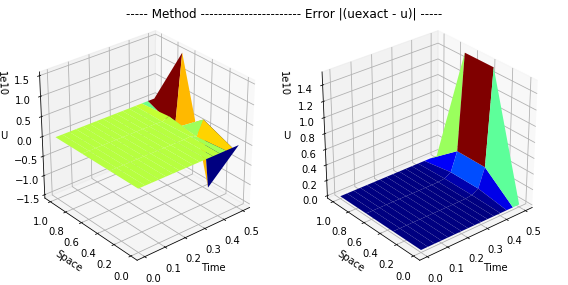

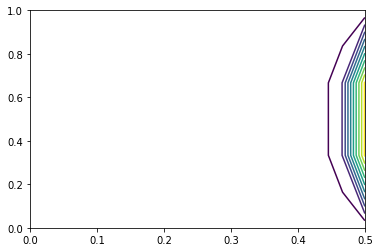

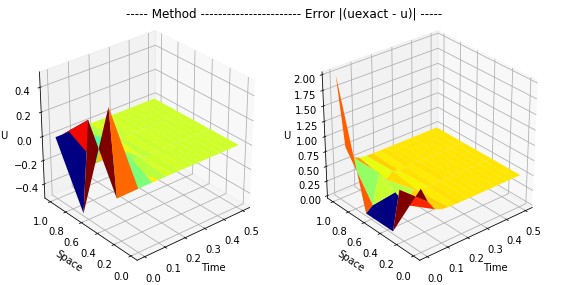

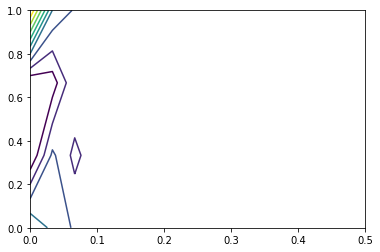

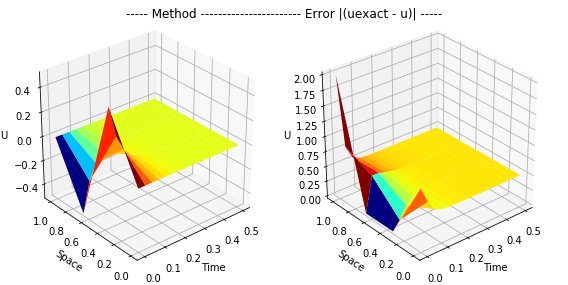

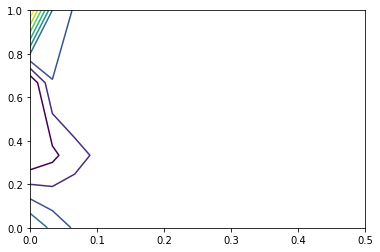

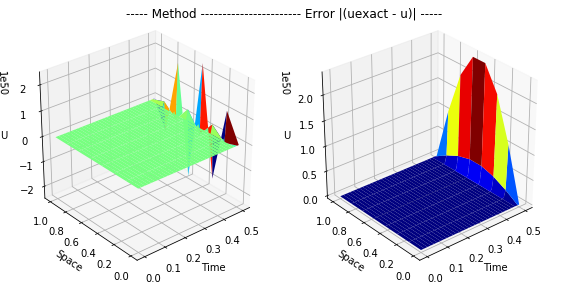

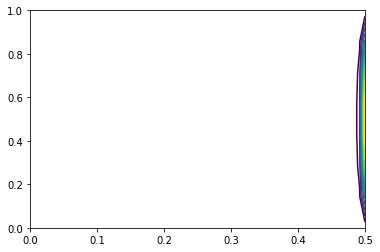

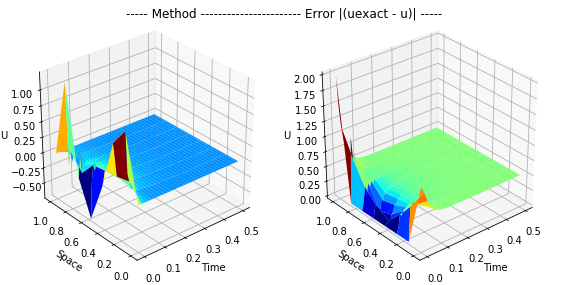

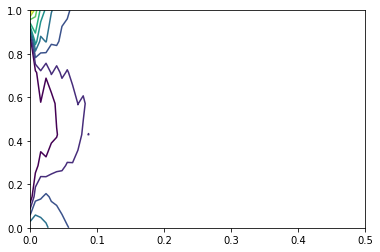

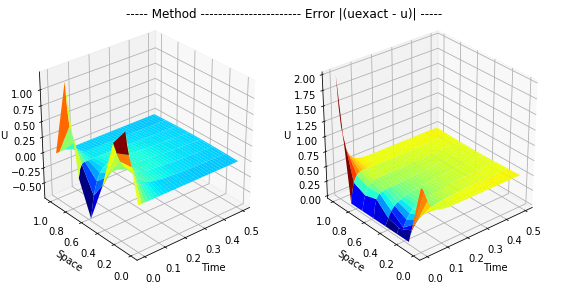

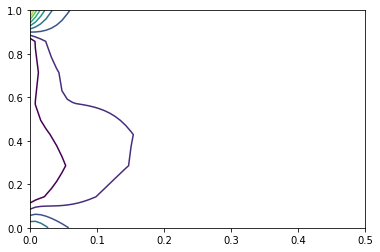

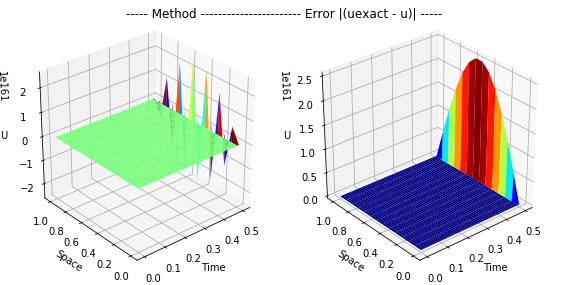

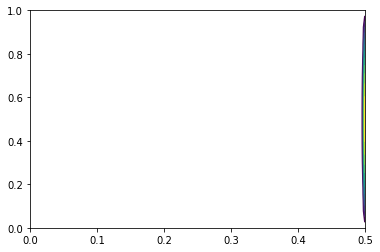

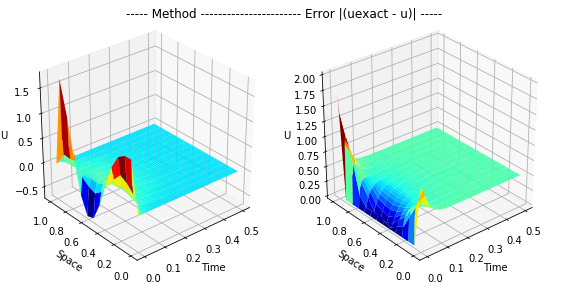

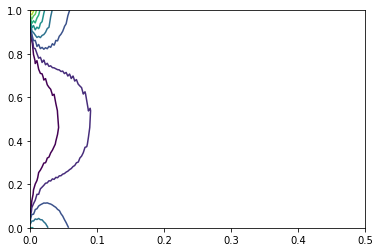

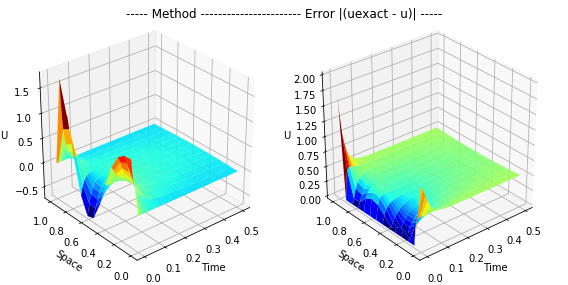

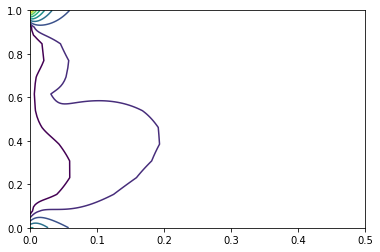

In [169]:
""" 
Comparison:
"""
lambd = [2, 1.0/2.0, 1.0/6.0]
M = [4, 8, 14]
#10, 12,

for i in range(len(M)):
    for j in range(len(lambd)):
        Uexact, x, t = ExactSolution(M[i])
        
        print("<---- M = ", M[i],", N = ", M[i]**2,", Lambda = ",round(lambd[j],2),"---->")
        U_ftcs, tspanf, xspanf = ForwardEuler(M[i], lambd[j])
        surfaceplot(U_ftcs, Uexact, tspanf, xspanf)


<---- M =  4 , N =  16 , Lambda =  2 ---->
<---- M =  4 , N =  16 , Lambda =  0.5 ---->
<---- M =  4 , N =  16 , Lambda =  0.17 ---->
<---- M =  8 , N =  64 , Lambda =  2 ---->
<---- M =  8 , N =  64 , Lambda =  0.5 ---->
<---- M =  8 , N =  64 , Lambda =  0.17 ---->
<---- M =  14 , N =  196 , Lambda =  2 ---->
<---- M =  14 , N =  196 , Lambda =  0.5 ---->
<---- M =  14 , N =  196 , Lambda =  0.17 ---->


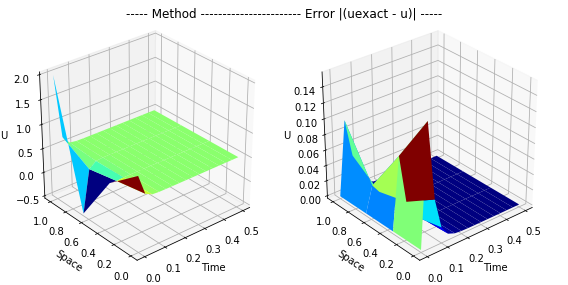

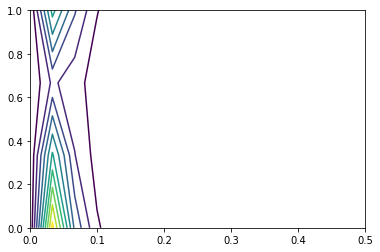

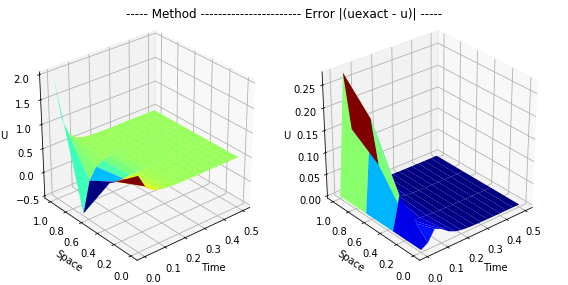

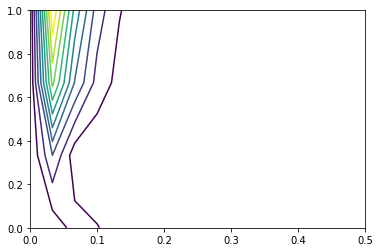

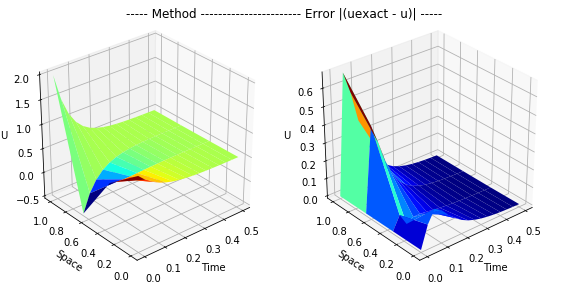

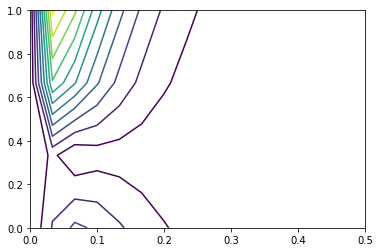

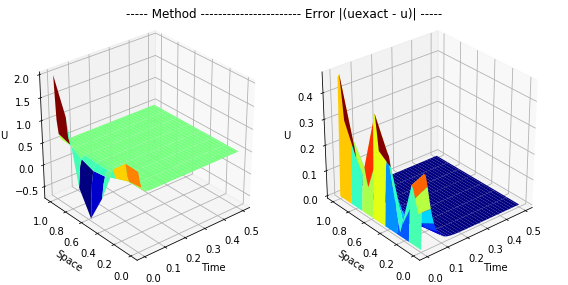

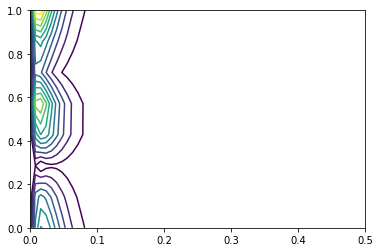

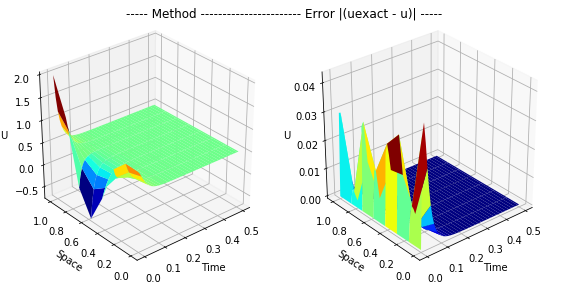

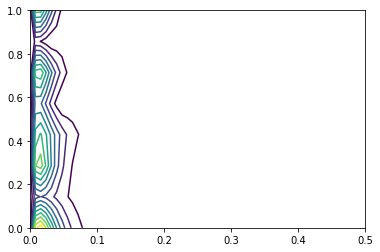

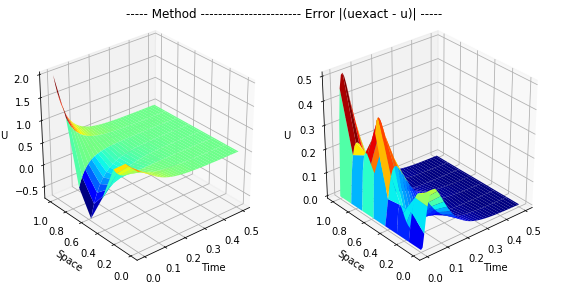

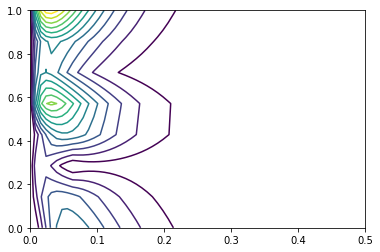

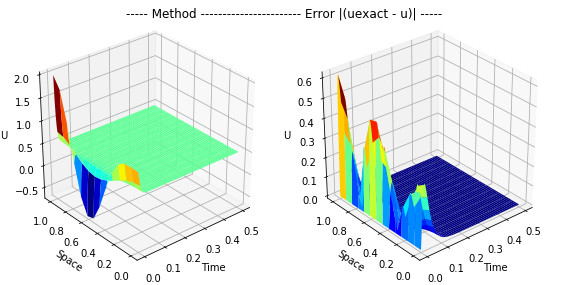

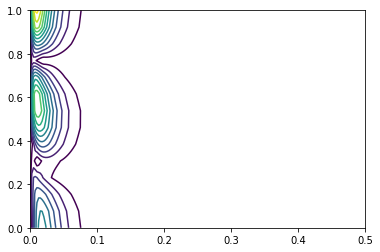

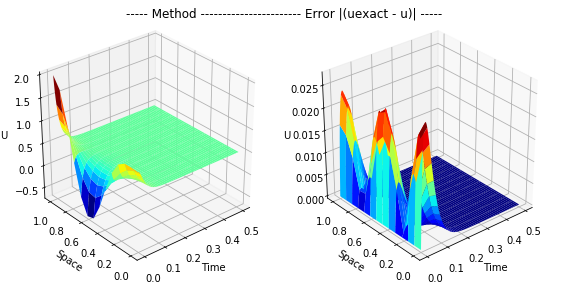

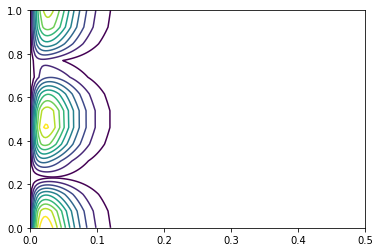

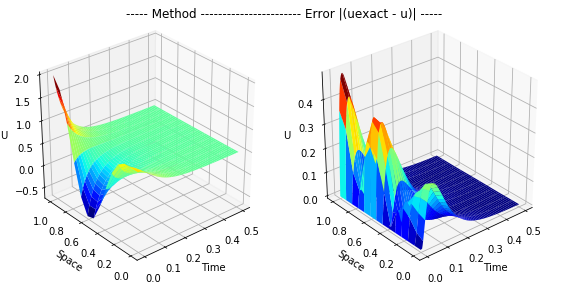

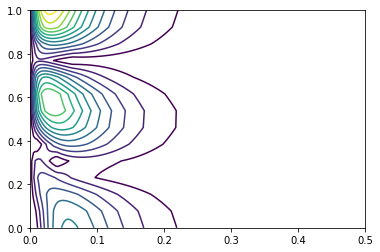

In [170]:
""" 
Comparison:
"""
lambd = [2, 1.0/2.0, 1.0/6.0]
M = [4, 8, 14]
#10, 12,

for i in range(len(M)):
    for j in range(len(lambd)):
        Uexact, x, t = ExactSolution(M[i])
        
        print("<---- M = ", M[i],", N = ", M[i]**2,", Lambda = ",round(lambd[j],2),"---->")
        U_btcs, tspanb, xspanb = BackwardEuler(M[i], lambd[j])
        surfaceplot(U_btcs, Uexact, tspanb, xspanb)

<---- M =  4 , N =  16 , Lambda =  2 ---->
<---- M =  4 , N =  16 , Lambda =  0.5 ---->
<---- M =  4 , N =  16 , Lambda =  0.17 ---->
<---- M =  8 , N =  64 , Lambda =  2 ---->
<---- M =  8 , N =  64 , Lambda =  0.5 ---->
<---- M =  8 , N =  64 , Lambda =  0.17 ---->
<---- M =  14 , N =  196 , Lambda =  2 ---->
<---- M =  14 , N =  196 , Lambda =  0.5 ---->
<---- M =  14 , N =  196 , Lambda =  0.17 ---->


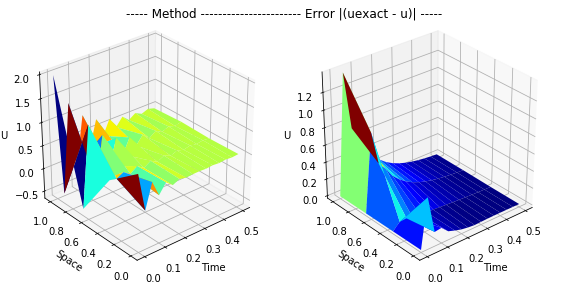

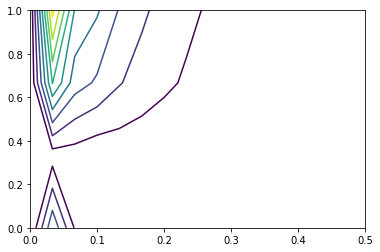

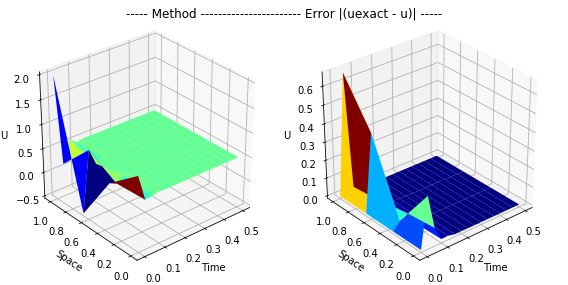

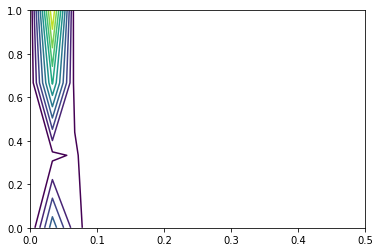

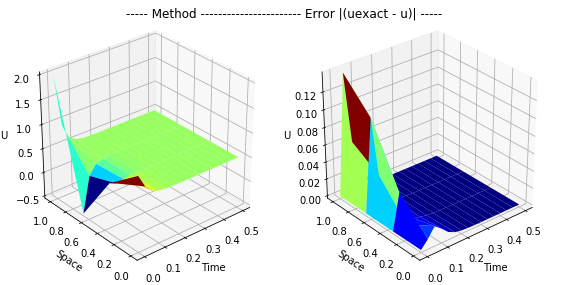

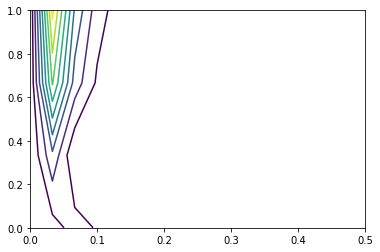

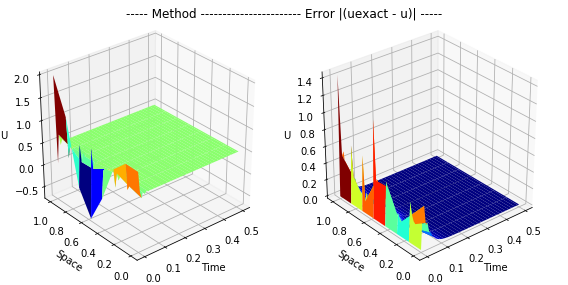

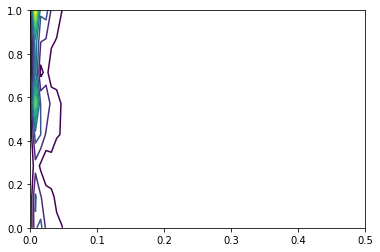

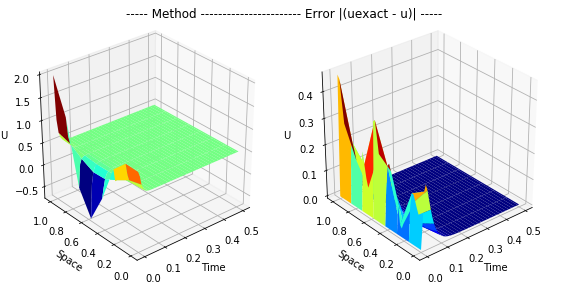

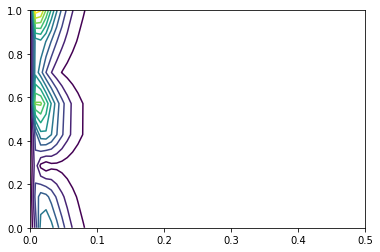

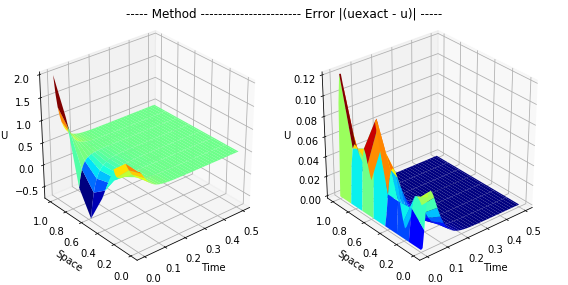

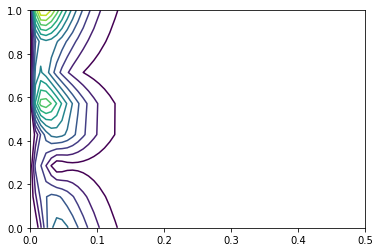

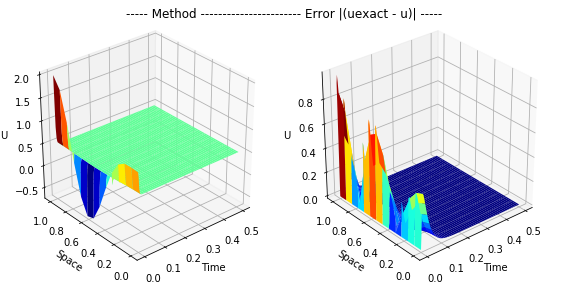

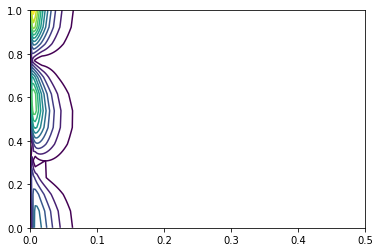

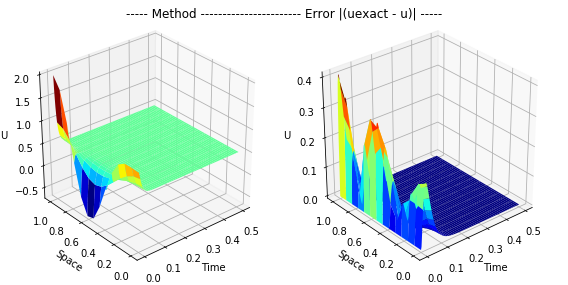

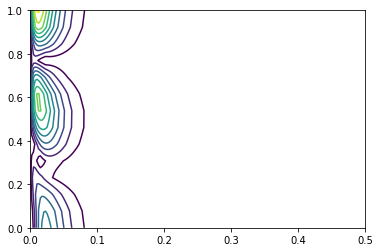

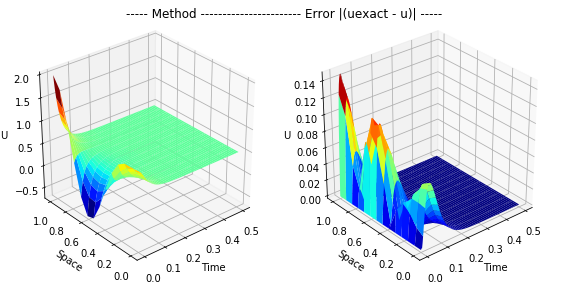

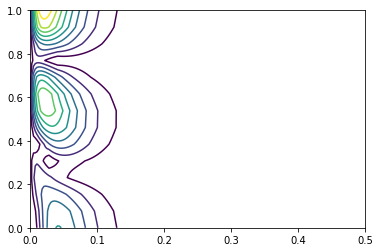

In [171]:
""" 
Comparison:
"""
lambd = [2, 1.0/2.0, 1.0/6.0]
M = [4, 8, 14]
#10, 12,

for i in range(len(M)):
    for j in range(len(lambd)):
        Uexact, x, t = ExactSolution(M[i])
        
        print("<---- M = ", M[i],", N = ", M[i]**2,", Lambda = ",round(lambd[j],2),"---->")
        U_cn, tspanc, xspanc = CrankNicolson(M[i], lambd[j])
        surfaceplot(U_cn, Uexact, tspanc, xspanc)
        

In [172]:
""" 
Comparison:
"""
lambd = [2, 1.0/2.0, 1.0/6.0]
M = [4, 8, 10, 12, 14]

for i in range(len(M)):
    for j in range(len(lambd)):
        Uexact, x, t = ExactSolution(M[i])
        U_ftcs, tspanf, xspanf = ForwardEuler(M[i], lambd[j])
        U_btcs, tspanb, xspanb = BackwardEuler(M[i], lambd[j])
        U_cn, tspanc, xspanc = CrankNicolson(M[i], lambd[j])
        
        print("<---- M = ", M[i],", N = ", M[i]**2,", Lambda = ",round(lambd[j],2),"---->")
        print("exact: \n", Uexact)
        print("FTCS error: \n", abs(Uexact - U_ftcs))
        print("BTCS error: \n", abs(Uexact - U_btcs))
        print("CN error: \n", abs(Uexact - U_cn))
        
        #FALTA FAZER O ERRO DE CADA UM COM A EXATA
        
        print("<--------------------------------------------------------------->\n\n")

<---- M =  4 , N =  16 , Lambda =  2 ---->
exact: 
 [[ 1.          0.7423335   0.5706018   0.51922691  0.50517206  0.50138803
   0.50037234  0.50009987  0.50002679  0.50000718  0.50000193  0.50000052
   0.50000014  0.50000004  0.50000001  0.5       ]
 [ 0.5         0.39177657  0.46536922  0.49042124  0.49741576  0.49930608
   0.49981384  0.49995006  0.49998661  0.49999641  0.49999904  0.49999974
   0.49999993  0.49999998  0.5         0.5       ]
 [-0.5         0.3400033   0.46268875  0.49028246  0.49740858  0.49930571
   0.49981382  0.49995006  0.49998661  0.49999641  0.49999904  0.49999974
   0.49999993  0.49999998  0.5         0.5       ]
 [ 2.          0.79410676  0.57328227  0.51936569  0.50517925  0.5013884
   0.50037236  0.50009987  0.50002679  0.50000718  0.50000193  0.50000052
   0.50000014  0.50000004  0.50000001  0.5       ]]
FTCS error: 
 [[1.00000000e+00 7.42333496e-01 5.70601803e-01 5.19226915e-01
  5.05172064e-01 5.01388029e-01 5.00372338e-01 5.00099871e-01
  5.00026787e-

<---- M =  8 , N =  64 , Lambda =  0.17 ---->
exact: 
 [[ 1.          0.98395412  0.91230495  0.83032079  0.75575938  0.69402495
   0.64532418  0.60795818  0.57977094  0.55873471  0.54314396  0.53164167
   0.52318133  0.516971    0.51241846  0.50908421  0.50664373  0.50485816
   0.50355213  0.50259703  0.50189865  0.50138803  0.50101471  0.50074179
   0.50054227  0.50039642  0.50028979  0.50021184  0.50015486  0.50011321
   0.50008275  0.5000605   0.50004422  0.50003233  0.50002363  0.50001728
   0.50001263  0.50000923  0.50000675  0.50000493  0.50000361  0.50000264
   0.50000193  0.50000141  0.50000103  0.50000075  0.50000055  0.5000004
   0.50000029  0.50000021  0.50000016  0.50000011  0.50000008  0.50000006
   0.50000004  0.50000003  0.50000002  0.50000002  0.50000001  0.50000001
   0.50000001  0.50000001  0.5         0.5       ]
 [ 1.01222933  0.90080433  0.80601763  0.73013879  0.67141478  0.62687804
   0.59352616  0.56875268  0.55044882  0.53697253  0.52707377  0.51981421
   0.51

<---- M =  10 , N =  100 , Lambda =  0.5 ---->
exact: 
 [[ 1.          0.99997879  0.96729644  0.91966506  0.8673265   0.81594574
   0.76842348  0.72602492  0.68907706  0.65739475  0.6305371   0.60795818
   0.58909285  0.57340281  0.560399    0.54965007  0.54078302  0.5334798
   0.52747181  0.52253395  0.51847853  0.5151497   0.51241846  0.51017829
   0.50834139  0.50683545  0.50560105  0.50458934  0.50376024  0.50308083
   0.50252412  0.50206798  0.50169424  0.50138803  0.50113715  0.50093162
   0.50076323  0.50062527  0.50051225  0.50041965  0.5003438   0.50028165
   0.50023074  0.50018903  0.50015486  0.50012687  0.50010393  0.50008515
   0.50006975  0.50005715  0.50004682  0.50003835  0.50003142  0.50002574
   0.50002109  0.50001728  0.50001415  0.50001159  0.5000095   0.50000778
   0.50000637  0.50000522  0.50000428  0.50000351  0.50000287  0.50000235
   0.50000193  0.50000158  0.50000129  0.50000106  0.50000087  0.50000071
   0.50000058  0.50000048  0.50000039  0.50000032  0.5000

CN error: 
 [[0.00000000e+00 1.80858259e-03 9.16195583e-03 2.38323970e-02
  3.77000781e-02 4.88340745e-02 5.66883775e-02 6.14124418e-02
  6.34611225e-02 6.33824823e-02 6.17094378e-02 5.89105660e-02
  5.53734374e-02 5.14048532e-02 4.72390240e-02 4.30487140e-02
  3.89567200e-02 3.50464096e-02 3.13708029e-02 2.79600898e-02
  2.48276765e-02 2.19749442e-02 1.93949276e-02 1.70751107e-02
  1.49995214e-02 1.31502716e-02 1.15086716e-02 1.00560158e-02
  8.77412142e-03 7.64568193e-03 6.65448310e-03 5.78551973e-03
  5.02504069e-03 4.36054396e-03 3.78073772e-03 3.27547919e-03
  2.83570036e-03 2.45332649e-03 2.12119234e-03 1.83295894e-03
  1.58303331e-03 1.36649232e-03 1.17901155e-03 1.01679971e-03
  8.76538485e-04 7.55328049e-04 6.50637797e-04 5.60262150e-04
  4.82281046e-04 4.15024767e-04 3.57042724e-04 3.07075843e-04
  2.64032202e-04 2.26965573e-04 1.95056576e-04 1.67596158e-04
  1.43971115e-04 1.23651454e-04 1.06179349e-04 9.11595172e-05
  7.82508437e-05 6.71590885e-05 5.76305549e-05 4.94465905e

<---- M =  12 , N =  144 , Lambda =  0.17 ---->
exact: 
 [[1.         1.00455684 0.99009831 ... 0.5        0.5        0.5       ]
 [1.01382317 0.99277507 0.9623731  ... 0.5        0.5        0.5       ]
 [0.98657243 0.91401412 0.85343353 ... 0.5        0.5        0.5       ]
 ...
 [0.84425759 0.80969446 0.77696511 ... 0.5        0.5        0.5       ]
 [1.6686839  1.47280125 1.31424201 ... 0.5        0.5        0.5       ]
 [2.         1.73757709 1.52741699 ... 0.5        0.5        0.5       ]]
FTCS error: 
 [[1.         1.00455684 0.99009831 ... 0.5        0.5        0.5       ]
 [0.         0.15246422 0.24276518 ... 0.49168473 0.49179964 0.49191286]
 [0.         0.04239001 0.04712953 ... 0.48405892 0.48427859 0.48449507]
 ...
 [0.         0.02076765 0.01563267 ... 0.48428372 0.4844915  0.48469671]
 [0.         0.21963572 0.34038797 ... 0.49181834 0.49192618 0.4920327 ]
 [2.         1.73757709 1.52741699 ... 0.5        0.5        0.5       ]]
BTCS error: 
 [[0.00000000e+00 3.22482320